In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
test = pd.read_csv('data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [4]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
210101,R.MDKVHSEAER.L,QQKVLQQRMDKVHSE,KVHSEAERLEARFQD,VLQQRMDKVHSEAER,-,sp|Q96M63|CC114_HUMAN,MDKVHSEAER,0


In [5]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [6]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(215352, 39) (215352, 30) (215352, 15) (215352, 15) (215352, 15) (215352, 15) (215352,)
(53838, 39) (53838, 30) (53838, 15) (53838, 15) (53838, 15) (53838, 15) (53838,)
(67298, 39) (67298, 30) (67298, 15) (67298, 15) (67298, 15) (67298, 15) (67298,)


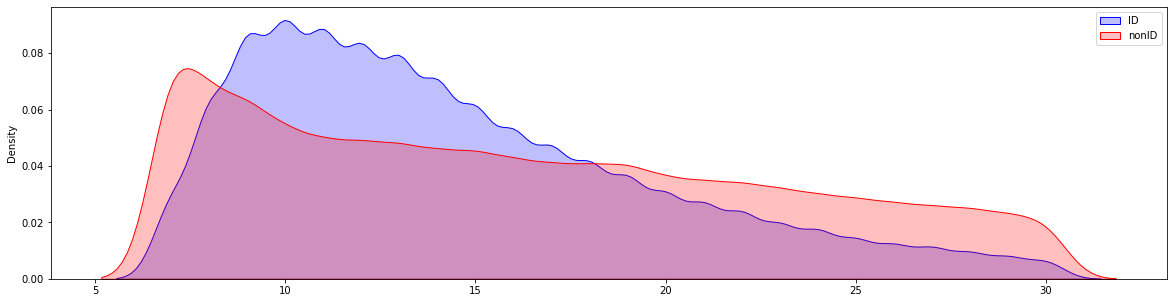

In [9]:
viz = pd.concat([train, val, test], axis=0).reset_index(drop=True)
p = viz.loc[viz.ID==1]
n = viz.loc[viz.ID==0]
pl = p.PEP.apply(lambda x: len(x)).values
nl = n.PEP.apply(lambda x: len(x)).values
plt.figure(figsize=(20,5))
sns.kdeplot(pl, shade=True, color='blue')
sns.kdeplot(nl, shade=True, color='red')
plt.legend(['ID', 'nonID'])
plt.show()

# Train

In [7]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [8]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# high param

In [13]:
pep = tf.keras.layers.Input(shape=((30,)))
input1_ = tf.keras.layers.Embedding(21, 32, input_length=30, mask_zero=True)(pep)
input1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(input1_)

input2 = tf.keras.layers.Input(shape=((39,)))  # peptide info

n = tf.keras.layers.Input(shape=((15,)))
input3_ = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(n)
input3 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(input3_)

c = tf.keras.layers.Input(shape=((15,)))
input4_ = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(c)
input4 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(input4_)

m1 = tf.keras.layers.Input(shape=((15,)))
input5_ = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(m1)
input5 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(input5_)

m2 = tf.keras.layers.Input(shape=((15,)))
input6_ = tf.keras.layers.Embedding(21, 16, input_length=15, mask_zero=True)(m2)
input6 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(input6_)




reshap1 = keras.backend.reshape(input1, [-1, 30, 32, 1])
cnn1 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, strides=1, padding='same')
    )(reshap1)
avgpool1 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.AveragePooling1D(pool_size=2)
    )(cnn1)
flat1 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Flatten()
    )(avgpool1)
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(flat1)
net_lstm_ = tf.keras.layers.Dense(16, activation='relu')(lstm1)
net_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_lstm_)

net_dense1_ = tf.keras.layers.Dense(32, activation='relu')(input2)
net_dense1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_dense1_)

reshap3 = keras.backend.reshape(input3, [-1, 15, 16, 1])
cnn3 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Conv1D(
        filters=16, kernel_size=2, strides=1, padding='same')
    )(reshap3)
avgpool3 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.AveragePooling1D(pool_size=2)
    )(cnn3)
flat3 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Flatten()
    )(avgpool3)
digest_n = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(flat3)
net_n_ = tf.keras.layers.Dense(8, activation='relu')(digest_n)
net_n = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_n_)

reshap4 = keras.backend.reshape(input4, [-1, 15, 16, 1])
cnn4 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Conv1D(
        filters=16, kernel_size=2, strides=1, padding='same')
    )(reshap4)
avgpool4 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.AveragePooling1D(pool_size=2)
    )(cnn4)
flat4 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Flatten()
    )(avgpool4)
digest_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(flat4)
net_c_ = tf.keras.layers.Dense(8, activation='relu')(digest_c)
net_c = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_c_)

reshap5 = keras.backend.reshape(input5, [-1, 15, 16, 1])
cnn5 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Conv1D(
        filters=16, kernel_size=2, strides=1, padding='same')
    )(reshap5)
avgpool5 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.AveragePooling1D(pool_size=2)
    )(cnn5)
flat5 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Flatten()
    )(avgpool5)
digest_m1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(flat5)
net_m1_ = tf.keras.layers.Dense(8, activation='relu')(digest_m1)
net_m1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m1_)

reshap6 = keras.backend.reshape(input6, [-1, 15, 16, 1])
cnn6 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Conv1D(
        filters=16, kernel_size=2, strides=1, padding='same')
    )(reshap6)
avgpool6 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.AveragePooling1D(pool_size=2)
    )(cnn6)
flat6 = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Flatten()
    )(avgpool6)
digest_m2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(flat6)
net_m2_ = tf.keras.layers.Dense(8, activation='relu')(digest_m2)
net_m2 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m2_)






cnn1 = tf.keras.layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same')(input1)
lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(cnn1)
net_lstm_ = tf.keras.layers.Dense(16, activation='relu')(lstm1)
net_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_lstm_)

net_dense1_ = tf.keras.layers.Dense(32, activation='relu')(input2)
net_dense1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_dense1_)

cnn3 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, strides=1, padding='same')(input3)
digest_n = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(cnn3)
net_n_ = tf.keras.layers.Dense(8, activation='relu')(digest_n)
net_n = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_n_)

cnn4 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, strides=1, padding='same')(input4)
digest_c = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(cnn4)
net_c_ = tf.keras.layers.Dense(8, activation='relu')(digest_c)
net_c = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_c_)

cnn5 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, strides=1, padding='same')(input5)
digest_m1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(cnn5)
net_m1_ = tf.keras.layers.Dense(8, activation='relu')(digest_m1)
net_m1 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m1_)

cnn6 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, strides=1, padding='same')(input6)
digest_m2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8))(cnn6)
net_m2_ = tf.keras.layers.Dense(8, activation='relu')(digest_m2)
net_m2 = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_m2_)








merge = tf.keras.layers.concatenate([net_lstm, 
                                     net_dense1,
                                     net_n,
                                     net_c,
                                     net_m1,
                                     net_m2])

net1 = tf.keras.layers.Dense(64, activation='relu')(merge)
net1_drop = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net1)
net3 = tf.keras.layers.Dense(32, activation='relu')(net1_drop)
net3_drop = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net3)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net3_drop)

model_high = tf.keras.Model(inputs=[pep, input2,
                              n, c,
                              m1, m2],
                       outputs=[output])

model_high.summary()

model_high.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=50)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 15)]         0                                            
____________________________________________________________________________________________

In [14]:
history = model_high.fit([pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=300,
                    batch_size=128,
                    validation_data=([pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es]
                        )

Epoch 1/300
1683/1683 [==============================] - 50s 22ms/step - loss: 7.5551 - accuracy: 0.5105 - val_loss: 0.6885 - val_accuracy: 0.5256
Epoch 2/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.7766 - accuracy: 0.5292 - val_loss: 0.6754 - val_accuracy: 0.6300
Epoch 3/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.6730 - accuracy: 0.6112 - val_loss: 0.5125 - val_accuracy: 0.7651
Epoch 4/300
1683/1683 [==============================] - 34s 20ms/step - loss: 0.5526 - accuracy: 0.7360 - val_loss: 0.4745 - val_accuracy: 0.7793
Epoch 5/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.5062 - accuracy: 0.7663 - val_loss: 0.4515 - val_accuracy: 0.7908
Epoch 6/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.4794 - accuracy: 0.7814 - val_loss: 0.4459 - val_accuracy: 0.7923
Epoch 7/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.4661 - accuracy: 0.7862 - val_loss: 0

1683/1683 [==============================] - 33s 20ms/step - loss: 0.3744 - accuracy: 0.8340 - val_loss: 0.3777 - val_accuracy: 0.8328
Epoch 112/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3755 - accuracy: 0.8321 - val_loss: 0.3716 - val_accuracy: 0.8346
Epoch 113/300
1683/1683 [==============================] - 34s 20ms/step - loss: 0.3741 - accuracy: 0.8337 - val_loss: 0.3722 - val_accuracy: 0.8351
Epoch 114/300
1683/1683 [==============================] - 34s 20ms/step - loss: 0.3747 - accuracy: 0.8322 - val_loss: 0.3739 - val_accuracy: 0.8335
Epoch 115/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3725 - accuracy: 0.8337 - val_loss: 0.3727 - val_accuracy: 0.8347
Epoch 116/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3718 - accuracy: 0.8354 - val_loss: 0.3734 - val_accuracy: 0.8344
Epoch 117/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3743 - accuracy: 0.8323 - val_loss: 0

1683/1683 [==============================] - 34s 20ms/step - loss: 0.3644 - accuracy: 0.8377 - val_loss: 0.3682 - val_accuracy: 0.8361
Epoch 167/300
1683/1683 [==============================] - 34s 20ms/step - loss: 0.3655 - accuracy: 0.8378 - val_loss: 0.3702 - val_accuracy: 0.8358
Epoch 168/300
1683/1683 [==============================] - 34s 20ms/step - loss: 0.3633 - accuracy: 0.8386 - val_loss: 0.3685 - val_accuracy: 0.8375
Epoch 169/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3659 - accuracy: 0.8386 - val_loss: 0.3680 - val_accuracy: 0.8373
Epoch 170/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3655 - accuracy: 0.8382 - val_loss: 0.3677 - val_accuracy: 0.8377
Epoch 171/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3657 - accuracy: 0.8380 - val_loss: 0.3725 - val_accuracy: 0.8352
Epoch 172/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3649 - accuracy: 0.8375 - val_loss: 0

1683/1683 [==============================] - 33s 20ms/step - loss: 0.3580 - accuracy: 0.8412 - val_loss: 0.3672 - val_accuracy: 0.8374
Epoch 222/300
1683/1683 [==============================] - 34s 20ms/step - loss: 0.3589 - accuracy: 0.8412 - val_loss: 0.3647 - val_accuracy: 0.8390
Epoch 223/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3601 - accuracy: 0.8402 - val_loss: 0.3670 - val_accuracy: 0.8378
Epoch 224/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3587 - accuracy: 0.8416 - val_loss: 0.3669 - val_accuracy: 0.8382
Epoch 225/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3603 - accuracy: 0.8401 - val_loss: 0.3665 - val_accuracy: 0.8387
Epoch 226/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3611 - accuracy: 0.8401 - val_loss: 0.3655 - val_accuracy: 0.8383
Epoch 227/300
1683/1683 [==============================] - 34s 20ms/step - loss: 0.3592 - accuracy: 0.8397 - val_loss: 0

1683/1683 [==============================] - 34s 20ms/step - loss: 0.3548 - accuracy: 0.8426 - val_loss: 0.3657 - val_accuracy: 0.8386
Epoch 277/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3552 - accuracy: 0.8439 - val_loss: 0.3650 - val_accuracy: 0.8386
Epoch 278/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3564 - accuracy: 0.8433 - val_loss: 0.3648 - val_accuracy: 0.8386
Epoch 279/300
1683/1683 [==============================] - 33s 20ms/step - loss: 0.3548 - accuracy: 0.8431 - val_loss: 0.3639 - val_accuracy: 0.8389
Epoch 280/300
1683/1683 [==============================] - 34s 20ms/step - loss: 0.3559 - accuracy: 0.8425 - val_loss: 0.3655 - val_accuracy: 0.8381
Epoch 281/300
1683/1683 [==============================] - 34s 20ms/step - loss: 0.3562 - accuracy: 0.8428 - val_loss: 0.3664 - val_accuracy: 0.8393
Epoch 282/300
1683/1683 [==============================] - 34s 20ms/step - loss: 0.3539 - accuracy: 0.8447 - val_loss: 0

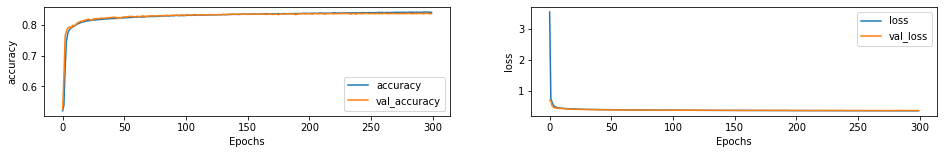

In [15]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

2104/2104 [==============================] - 15s 7ms/step - loss: 0.3609 - accuracy: 0.8373
Test Loss: 0.3608633279800415
Test Accuracy: 0.8372611403465271
              precision    recall  f1-score   support

           0       0.84      0.83      0.84     33706
           1       0.83      0.84      0.84     33592

    accuracy                           0.84     67298
   macro avg       0.84      0.84      0.84     67298
weighted avg       0.84      0.84      0.84     67298

rf auc : 0.9189278015040244


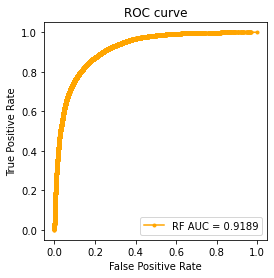

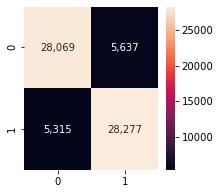

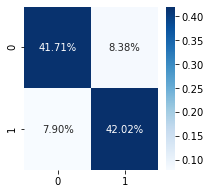

In [16]:
test_loss, test_acc = model_high.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

# digestibility Embedding Go!
  - using pre trained protein language model

In [ ]:
Orbitrap
- HCD
iTRAQ-4 Phospho	

Orbitrap -
HCD
Phospho	

Orbitrap -
HCD
TMT-10	

Human, Yeast, Mouse 
https://chemdata.nist.gov/dokuwiki/doku.php?id=peptidew:lib:mouse20130520
https://chemdata.nist.gov/dokuwiki/doku.php?id=peptidew:lib:yeast_it
            
https://chemdata.nist.gov/
https://chemdata.nist.gov/dokuwiki/doku.php?id=peptidew:start
https://chemdata.nist.gov/dokuwiki/doku.php?id=peptidew:cdownload